![Quora-1.png](attachment:Quora-1.png)

<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<h1>3. Exploratory Data Analysis </h1>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
print('Libraries Imported')

Libraries Imported


In [2]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

<h2> 3.1 Reading data and basic stats </h2>

In [3]:
df = pd.read_csv('train.csv')

print("Number of data points:", df.shape[0])

Number of data points: 404290


In [4]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [6]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

<Axes: xlabel='is_duplicate'>

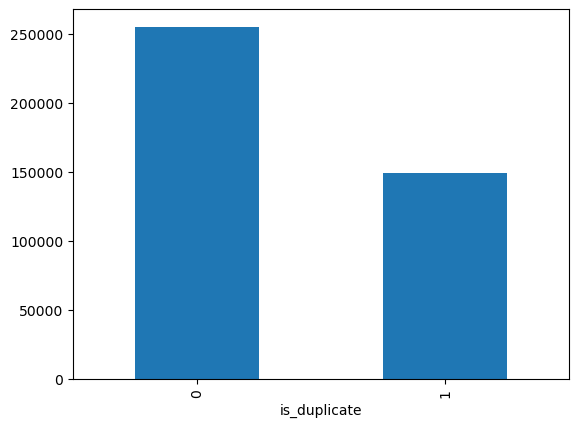

In [7]:
df.groupby('is_duplicate')['id'].count().plot.bar()

In [8]:
# Calculate the percentage split
percentage_split = df['is_duplicate'].value_counts(normalize=True) * 100

# Display the percentage split
print(percentage_split)

is_duplicate
0    63.080215
1    36.919785
Name: proportion, dtype: float64


In [9]:
type(df['is_duplicate'].value_counts(normalize=True))

pandas.core.series.Series

<h3> 3.2.2 Number of unique questions </h3>

In [10]:
# Concatenate unique values from qid1 and qid2 columns
unique_questions = pd.concat([df['qid1'], df['qid2']]).unique()

# Count the total number of unique questions
total_unique_questions = len(unique_questions)

# Display the total number of unique questions
print("Total number of unique questions based on qid1 and qid2:", total_unique_questions)


Total number of unique questions based on qid1 and qid2: 537933


In [11]:
# Concatenate qid1 and qid2 columns
all_questions = pd.concat([df['qid1'], df['qid2']])

# Count occurrences of each question ID
question_counts = all_questions.value_counts()

In [12]:
print(type(all_questions))
print(type(question_counts))
print(all_questions.head())
print(question_counts.head())
print(question_counts.info())

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
0    1
1    3
2    5
3    7
4    9
dtype: int64
2559     157
30782    120
4044     111
2561      88
14376     79
Name: count, dtype: int64
<class 'pandas.core.series.Series'>
Index: 537933 entries, 2559 to 537933
Series name: count
Non-Null Count   Dtype
--------------   -----
537933 non-null  int64
dtypes: int64(1)
memory usage: 8.2 MB
None


In [13]:
# Filter for questions that appear more than once
duplicate_questions = question_counts[question_counts > 1]
#unique_questions = question_counts[question_counts == 1]

# Calculate the total number of questions that appear more than once
total_duplicate_questions = len(duplicate_questions)
#total_unique_questions = len(unique_questions)

# Display the total number of questions that appear more than once
print("Total number of questions that appear more than once:", total_duplicate_questions)
print('Percentage Total number of questions that appear more than once:', total_duplicate_questions/total_unique_questions)

Total number of questions that appear more than once: 111780
Percentage Total number of questions that appear more than once: 0.20779539459375052


In [14]:
max_question_id = question_counts[question_counts == question_counts.max()].index[0]
max_question_count = question_counts.max()

print('Question ID {} got repeated the maximum number of times: {}'.format(max_question_id, max_question_count))

Question ID 2559 got repeated the maximum number of times: 157


In [15]:
question_counts[2559]

157

In [16]:
question_counts.sort_values()

340025      1
275326      1
275327      1
275330      1
275333      1
         ... 
14376      79
2561       88
4044      111
30782     120
2559      157
Name: count, Length: 537933, dtype: int64

In [17]:
print(question_counts[question_counts >= 88].index)
print(question_counts[question_counts >= 88])

Index([2559, 30782, 4044, 2561], dtype='int64')
2559     157
30782    120
4044     111
2561      88
Name: count, dtype: int64


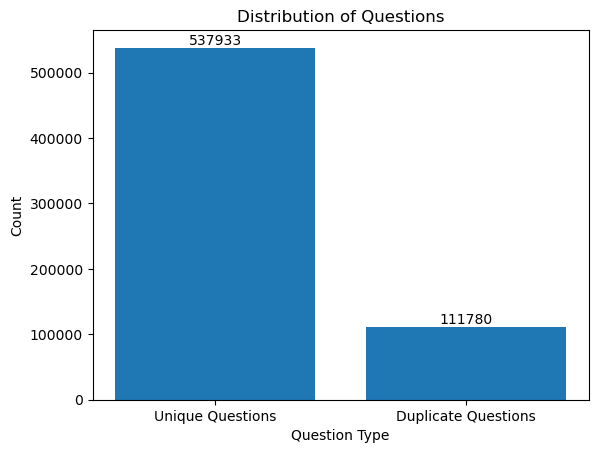

In [18]:
x = ['Unique Questions', 'Duplicate Questions']
y = [total_unique_questions, total_duplicate_questions]

# Create bar plot
bars = plt.bar(x, y)

# Add labels and title
plt.xlabel('Question Type')
plt.ylabel('Count')
plt.title('Distribution of Questions')

# # Add text annotations on top of each bar
# for i, v in enumerate(y):
#     plt.text(i, v, str(v), ha='center', va='bottom')

# Add text annotations on top of each bar
plt.bar_label(bars, fmt='%.0f', label_type='edge')

# Show plot
plt.show()

<h3>3.2.3 Checking for Duplicates </h3>

In [19]:
# Group by qid1 and qid2, and count occurrences
duplicate_counts = df.groupby(['qid1', 'qid2']).size()

# Filter for pairs with count greater than 1
duplicate_entries = duplicate_counts[duplicate_counts > 1]

# Display the duplicate entries
print(duplicate_entries)


Series([], dtype: int64)


In [20]:
query = """
SELECT qid1, qid2, COUNT(*) AS cnt
FROM df
GROUP BY 1, 2
HAVING COUNT(*) > 1
"""
result = pysqldf(query)
print(result)
print(type(result))

Empty DataFrame
Columns: [qid1, qid2, cnt]
Index: []
<class 'pandas.core.frame.DataFrame'>


<h3> 3.2.4 Number of occurrences of each question </h3>

In [21]:
query = """
select qid, count(*) as cnt
from(
SELECT qid1 as qid FROM df
UNION ALL
SELECT qid2 as qid from df    
)
group by 1
order by 2 desc
"""
# result = pysqldf(query)
# result

Maximum number of times a single question is repeated: 157



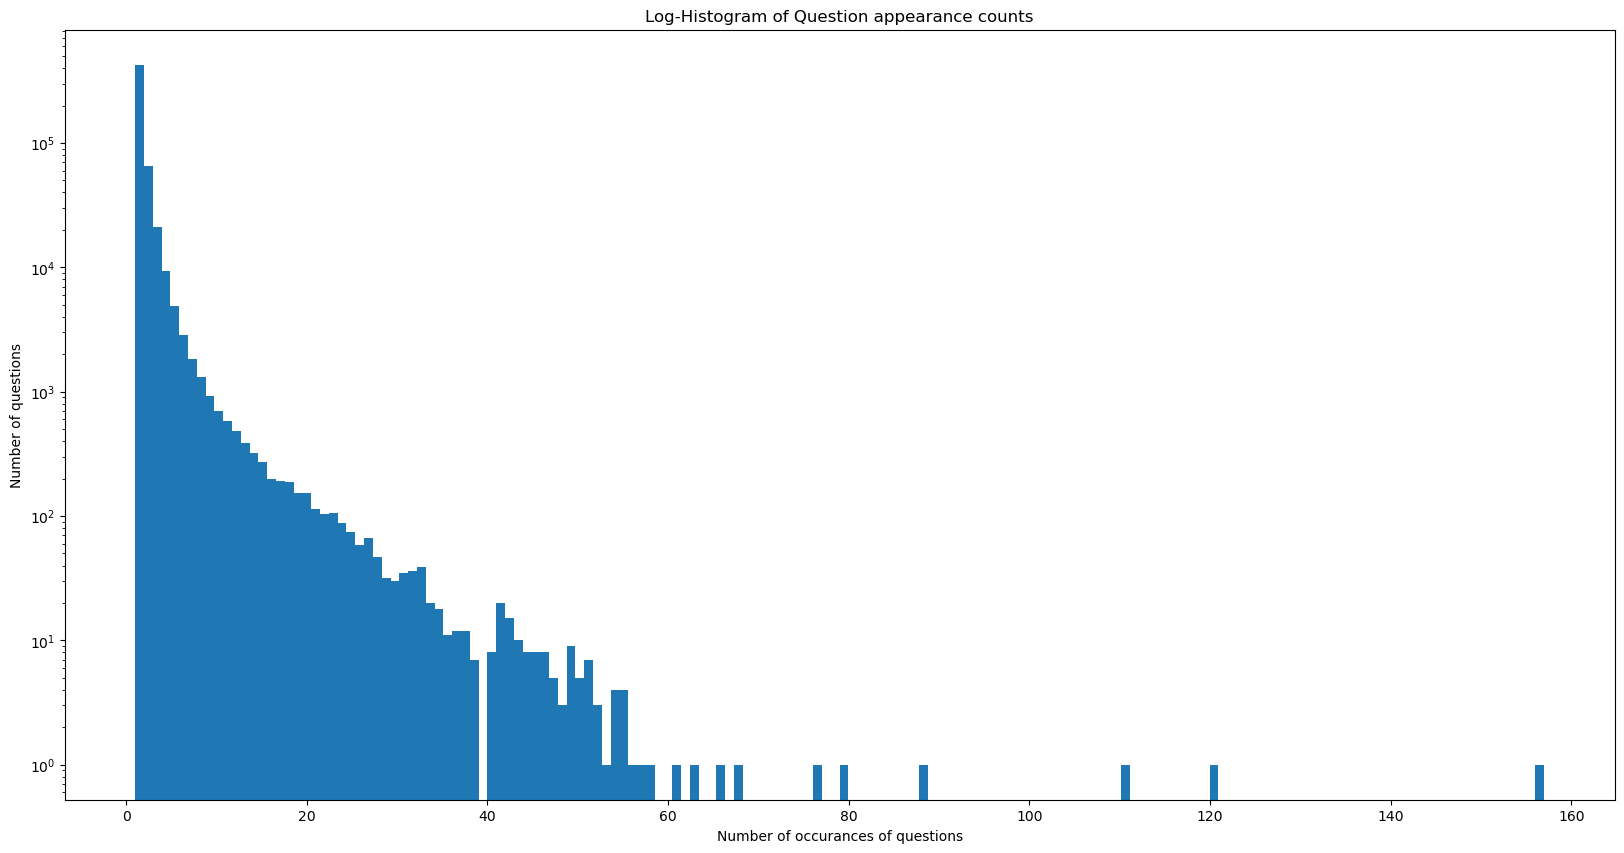

In [22]:
plt.figure(figsize = (20,10))
plt.hist(all_questions.value_counts(), bins=160)
# plt.yscale('log', nonposy='clip')
plt.yscale('log')
plt.title('Log-Histogram of Question appearance counts')
plt.xlabel('Number of occurances of questions')
plt.ylabel('Number of questions')
print('Maximum number of times a single question is repeated: {}\n'.format(max(all_questions.value_counts())))

<h3> 3.2.5 Checking for NULL values </h3>

In [23]:
nan_rows = df[df.isnull().any(axis=1) | df.isna().any(axis=1) | df.isin([None]).any(axis=1)]
nan_rows

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


- There are two rows with null values in question2 

In [24]:
df.fillna('', inplace=True)
df[df.isnull().any(axis=1) | df.isna().any(axis=1) | df.isin([None]).any(axis=1)]

,id,qid1,qid2,question1,question2,is_duplicate


<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [25]:
# Frequency of qid1's
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')

# Frequency of qid2's
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')

# Length of q1
df['q1len'] = df['question1'].str.len()

# Length of q2
df['q2len'] = df['question2'].str.len()

# Number of words in Question 1
df['q1_n_words'] = df['question1'].apply(lambda row: len(str(row).split()))

# Number of words in Question 2
df['q2_n_words'] = df['question2'].apply(lambda row: len(str(row).split()))

# Set of unique words in Question 1
df['word_set_q1'] = df['question1'].apply(lambda row: set(str(row).lower().split()))

# Set of unique words in Question 2
df['word_set_q2'] = df['question2'].apply(lambda row: set(str(row).lower().split()))

# Number of common unique words in Question 1 and Question 2
df['word_Common'] = df.apply(lambda row: len(row['word_set_q1'].intersection(row['word_set_q2'])), axis=1)

# Total num of words in Question 1 + Total num of words in Question 2
df['word_Total'] = df['q1_n_words'] + df['q2_n_words']

# Calculate word share
df['word_share'] = df['word_Common'] / df['word_Total']

# Sum total of frequency of qid1 and qid2
df['freq_q1+freq_q2'] = df['freq_qid1'] + df['freq_qid2']

# Absolute difference of frequency of qid1 and qid2
df['freq_q1-freq_q2'] = abs(df['freq_qid1'] - df['freq_qid2'])

# Drop temporary columns
df.drop(['word_set_q1', 'word_set_q2'], axis=1, inplace=True)

# Display the updated DataFrame with additional columns
print(df.head())


   id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  freq_qid1  \
0  What is the step by step guide to invest in sh...             0          1   
1  What would happen if the Indian government sto...             0          4   
2  How can Internet speed be increased by hacking...             0          1   
3  Find the remainder when [math]23^{24}[/math] i...             0          1   
4            Which fish would survive in salt water?             0          3   

   freq_qid2  q1len  q2len  q1_n_words  q2_n_words  word_Common  word_Total  \
0

<h3> 3.3.1 Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [28]:
print('Minimum length of questions in question1: ', min(df['q1_n_words']))
print('Minimum length of questions in question2: ', min(df['q2_n_words']))
print('Number of Questions with min length in question1: ', df[df['q1_n_words'] == 0].shape[0])
print('Number of Questions with min length in question2: ', df[df['q2_n_words'] == 0].shape[0])
print('Number of Questions with 1 length in question1: ', df[df['q1_n_words'] == 1].shape[0])
print('Number of Questions with 1 length in question2: ', df[df['q2_n_words'] == 1].shape[0])

Minimum length of questions in question1:  0
Minimum length of questions in question2:  0
Number of Questions with min length in question1:  1
Number of Questions with min length in question2:  2
Number of Questions with 1 length in question1:  69
Number of Questions with 1 length in question2:  25


<h4> 3.3.1.1 Feature: word_share </h4>

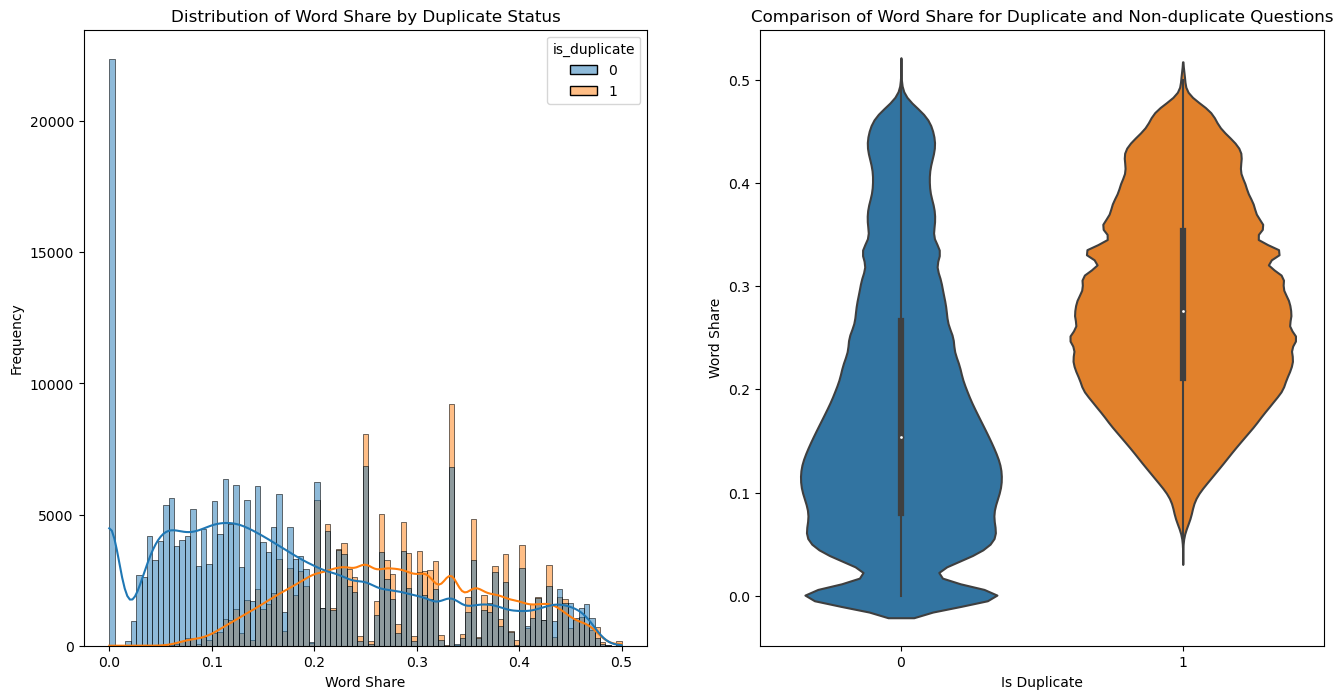

In [35]:
plt.figure(figsize=(16, 8))

# Distribution of word_share
plt.subplot(1,2,1)
# Create a histogram broken down by is_duplicate label
#sns.histplot(data=df, x='word_share', bins=50, hue='is_duplicate', kde=True)
sns.histplot(data=df, x='word_share',  hue='is_duplicate', kde=True)

plt.title('Distribution of Word Share by Duplicate Status')
plt.xlabel('Word Share')
plt.ylabel('Frequency')

# Comparison of Word Share for Duplicate and Non-duplicate Questions
plt.subplot(1,2,2)
sns.violinplot(x='is_duplicate', y='word_share', data=df)
plt.title('Comparison of Word Share for Duplicate and Non-duplicate Questions')
plt.xlabel('Is Duplicate')
plt.ylabel('Word Share')
plt.show()

In [36]:
# Correlation analysis
correlation = df['word_share'].corr(df['is_duplicate'])
print(f'Correlation between word_share and is_duplicate: {correlation}')

Correlation between word_share and is_duplicate: 0.38901499633392933


- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> 3.3.1.2 Feature: word_Common </h4>

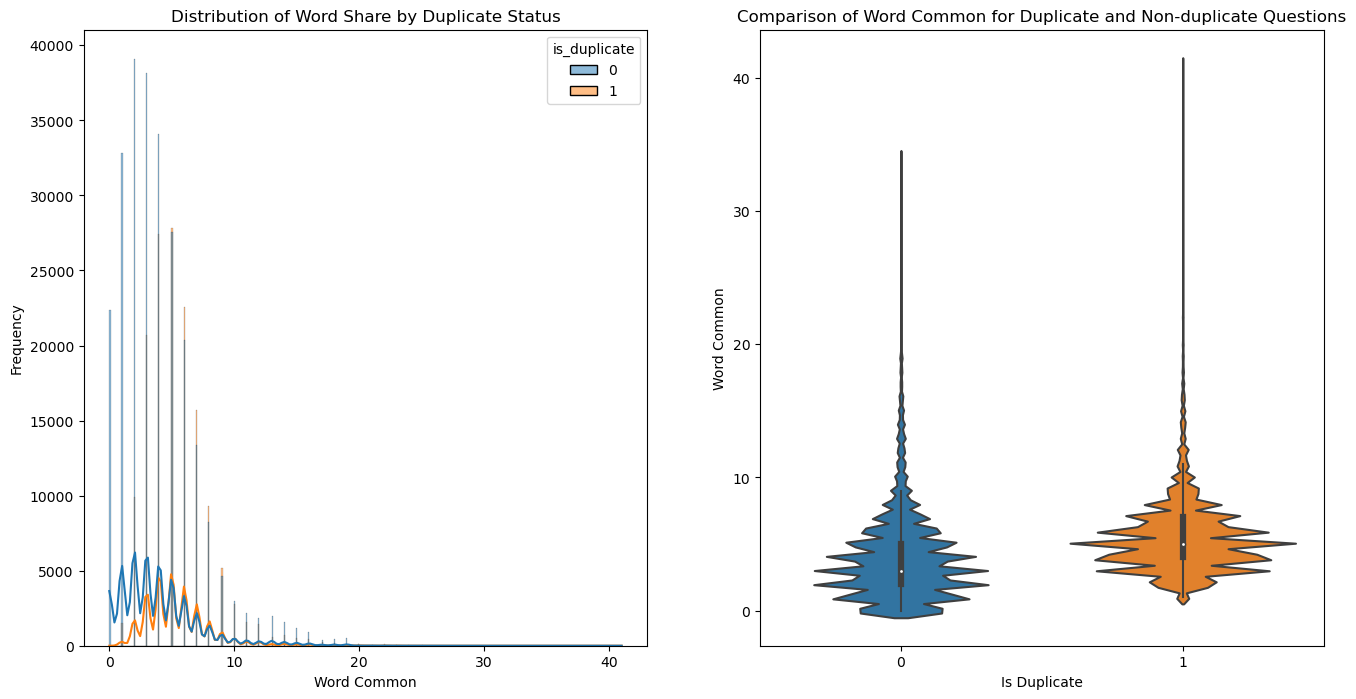

In [37]:
plt.figure(figsize=(16, 8))

# Distribution of word_share
plt.subplot(1,2,1)
# Create a histogram broken down by is_duplicate label
#sns.histplot(data=df, x='word_share', bins=50, hue='is_duplicate', kde=True)
sns.histplot(data=df, x='word_Common',  hue='is_duplicate', kde=True)

plt.title('Distribution of Word Share by Duplicate Status')
plt.xlabel('Word Common')
plt.ylabel('Frequency')

# Comparison of Word Share for Duplicate and Non-duplicate Questions
plt.subplot(1,2,2)
sns.violinplot(x='is_duplicate', y='word_Common', data=df)
plt.title('Comparison of Word Common for Duplicate and Non-duplicate Questions')
plt.xlabel('Is Duplicate')
plt.ylabel('Word Common')
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

In [38]:
# Save the DataFrame to a CSV file
df.to_csv('basic_features_df.csv', index=False)